In [33]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

# Add noise as a baseline
rng = np.random.default_rng(seed=44)
n_rows = len(train_df)
train_df['rng_bin'] = rng.binomial(n=1, p=0.5, size=n_rows)
train_df['rng_uniform'] = rng.uniform(low=train_df['price'].min(), high=train_df['price'].max(), size=n_rows)
train_df['rng_normal'] = rng.normal(loc=1, scale=10, size=n_rows)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Price is notably differerent from uniform

In [51]:
train_df['price'].mean(), train_df['rng_uniform'].mean()

(81.36217459275402, 82.47701268944861)

In [72]:
# Function to count decimal places
def count_decimal_places(value):
    if pd.isna(value):  # Handle NaN values
        return None
    value_str = str(value)
    if '.' in value_str:
        return len(value_str.split('.')[1])
    return 0


test_df['wc_decimal_count'] = test_df['weight_capacity'].apply(count_decimal_places)
test_df.loc[(test_df['wc_decimal_count'] > 1) & (test_df['wc_decimal_count'] < 14), 'wc_decimal_count'] = -1

train_df['wc_decimal_count'] = train_df['weight_capacity'].apply(count_decimal_places)
train_df.loc[(train_df['wc_decimal_count'] > 1) & (train_df['wc_decimal_count'] < 14), 'wc_decimal_count'] = -1

In [50]:
train_df['rng_uniform'] = rng.uniform(low=train_df['price'].min(), high=train_df['price'].max(), size=n_rows)
train_df['rng_uniform'].mean()

82.47701268944861

In [73]:
train_df_sample = train_df.sample(len(test_df))

grouped = train_df_sample.groupby(['wc_decimal_count'], as_index=False)['price'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')
grouped['diff'] = (grouped['mean'] - train_df['price'].mean()).round(3)
grouped

,wc_decimal_count,count,mean,diff
0,-1,12231,82.152419,0.790
1,1,3089,76.285036,-5.077
2,14,86444,81.788373,0.426
3,15,97667,80.899419,-0.463
4,16,569,77.106701,-4.255


In [74]:
train_df_sample = train_df.sample(len(test_df))

grouped = train_df_sample.groupby(['wc_decimal_count'], as_index=False)['price'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')
grouped['diff'] = (grouped['mean'] - train_df['price'].mean()).round(3)
grouped

,wc_decimal_count,count,mean,diff
0,-1,12562,82.486275,1.124
1,1,3059,76.786922,-4.575
2,14,86395,81.674547,0.312
3,15,97443,81.064384,-0.298
4,16,541,77.633539,-3.729


In [75]:
train_df_sample = train_df.sample(len(test_df))

grouped = train_df_sample.groupby(['wc_decimal_count'], as_index=False)['price'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')
grouped['diff'] = (grouped['mean'] - train_df['price'].mean()).round(3)
grouped

,wc_decimal_count,count,mean,diff
0,-1,12681,82.057203,0.695
1,1,3230,76.591439,-4.771
2,14,85680,81.662431,0.300
3,15,97877,81.101081,-0.261
4,16,532,75.698537,-5.664


In [76]:
train_df_sample = train_df.sample(len(test_df))

grouped = train_df_sample.groupby(['wc_decimal_count'], as_index=False)['price'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')
grouped['diff'] = (grouped['mean'] - train_df['price'].mean()).round(3)
grouped

,wc_decimal_count,count,mean,diff
0,-1,12615,82.334475,0.972
1,1,3166,76.762929,-4.599
2,14,85581,81.784243,0.422
3,15,98101,80.791898,-0.570
4,16,537,81.149866,-0.212


In [39]:
# train_df_sample = train_df.sample(len(test_df))

train_df_sample.groupby(['wc_decimal_count'], as_index=False)['rng_uniform'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')

,wc_decimal_count,count,mean
0,1,3205,82.584220
1,2,22,84.511886
2,11,91,77.896080
3,12,1006,81.240294
4,13,11369,82.458404
5,14,86143,82.388205
6,15,97618,82.383722
7,16,546,82.547464


In [23]:
num_col = 'weight_capacity'
even = train_df[train_df[num_col] == train_df[num_col].round(0)]
even

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,wc_decimal_count
172333,4,2,0,4,1,0,0,4,5.0,34.54100,1
105491,-1,3,0,8,1,1,-1,5,5.0,106.87364,1
264771,1,1,1,5,1,1,0,1,5.0,18.76894,1
259367,1,2,1,2,1,1,1,4,5.0,52.27204,1
142993,4,0,0,10,0,1,-1,2,5.0,23.94547,1
...,...,...,...,...,...,...,...,...,...,...,...
56684,4,0,2,9,0,1,2,4,5.0,122.51899,1
189797,1,0,2,7,0,0,0,1,5.0,84.03676,1
54806,0,2,0,4,0,1,2,4,5.0,77.84639,1
43758,-1,2,0,3,1,0,0,3,5.0,41.63380,1


In [24]:
test_df.loc[(test_df['wc_decimal_count'] > 1) & (test_df['wc_decimal_count'] < 10)]

,id,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,wc_decimal_count
1737,301737,3,3,0,7,0,1,2,4,10.581458,8
13535,313535,0,1,0,9,0,1,1,0,8.874174,8
21637,321637,-1,2,2,6,0,0,0,5,11.545700,4
58346,358346,2,0,1,4,1,-1,0,3,17.784008,7
60461,360461,3,1,-1,9,1,0,0,1,26.048500,4
82135,382135,1,1,1,1,1,0,2,3,7.098592,7
150023,450023,2,0,2,6,0,0,2,1,11.203867,9
172348,472348,2,0,0,7,0,1,0,5,15.938014,9
183038,483038,-1,2,1,8,0,1,2,2,13.571393,9
184097,484097,3,1,1,8,0,1,2,5,17.011120,5


In [17]:
test_df.groupby(['wc_decimal_count'], as_index=False)['compartments'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')

,wc_decimal_count,count,mean
0,1,3188,5.376412
1,4,2,7.500000
2,5,2,5.000000
3,7,2,2.500000
4,8,2,8.000000
5,9,3,7.000000
6,10,11,6.181818
7,11,109,5.422018
8,12,1055,5.555450
9,13,11450,5.416769


In [20]:
train_df['compartments'].mean(), test_df['compartments'].mean()

(5.44947, 5.442855)

In [31]:
train_df.groupby(['wc_decimal_count'], as_index=False)['rng_uniform'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')


,wc_decimal_count,count,mean
0,1,3057,83.254012
1,2,1,89.839614
2,3,3,108.241606
3,6,2,85.406161
4,7,2,87.675048
5,8,2,94.900547
6,9,1,16.127391
7,10,7,88.570175
8,11,83,91.584688
9,12,1015,82.586747


In [30]:
train_df.groupby(['wc_decimal_count'], as_index=False)['price'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')
# train_df.groupby(['wc_decimal_count'], as_index=False)['compartments'].agg(['count', 'mean']).sort_values(by='wc_decimal_count')

,wc_decimal_count,count,mean
0,1,3057,77.454248
1,2,1,109.846470
2,3,3,84.533850
3,6,2,29.691575
4,7,2,71.276120
5,8,2,67.038950
6,9,1,135.107360
7,10,7,47.806080
8,11,83,76.625106
9,12,1015,79.718226


In [ ]:
train_df[['weight_capacity', 'wc_decimal_count']]

KeyError: 'wc_decimal_places'

In [91]:
# Function to extract first n decimal places without rounding
def extract_decimal_places(value, n):
    if pd.isna(value):  # Handle NaN values
        return None
    value_str = str(value)
    if '.' in value_str:
        integer_part, decimal_part = value_str.split('.')
        truncated_decimal = decimal_part[:n]  # Get first n decimal places
        return float(f"{integer_part}.{truncated_decimal}") if truncated_decimal else float(integer_part)
    return float(value)  # No decimal point means return as is


def extract_decimal_part(value, n):
    if pd.isna(value):  # Handle NaN values
        return None
    value_str = str(value)
    if '.' in value_str:
        decimal_part = value_str.split('.')[1][:n]  # Get first n decimal places
        return decimal_part if decimal_part else '0'  # Ensure we return at least '0'
    return '0'  # If no decimal part, return '0'

# number of decimal places to extract)
n = 2
# train_df['truncated_weight_capacity'] = train_df['weight_capacity'].apply(lambda x: extract_decimal_places(x, n))
train_df['truncated_weight_capacity'] = train_df['weight_capacity'].apply(lambda x: extract_decimal_part(x, n))
train_df[['weight_capacity', 'truncated_weight_capacity']]

,weight_capacity,truncated_weight_capacity
0,11.611723,61
1,27.078537,07
2,16.643760,64
3,12.937220,93
4,17.749338,74
...,...,...
299995,12.730812,73
299996,26.633182,63
299997,11.898250,89
299998,6.175738,17


In [92]:
train_df.groupby(['truncated_weight_capacity'], as_index=False)['price'].agg(['count', 'mean'])

,truncated_weight_capacity,count,mean
0,0,4609,77.655159
1,00,2161,83.415557
2,01,3369,84.365676
3,02,1211,83.568611
4,03,2664,81.621842
...,...,...,...
97,95,4998,79.593580
98,96,4353,81.659940
99,97,4102,81.332308
100,98,3647,80.564998


In [84]:
num_col = 'weight_capacity'
not_even = train_df[train_df[num_col] != train_df[num_col].round(0)]

not_even.groupby(['wc_decimal_places'], as_index=False)['price'].agg(['count', 'mean'])

,wc_decimal_places,count,mean
0,1,1,128.321700
1,2,1,109.846470
2,3,3,84.533850
3,4,1,123.592370
4,6,3,31.692457
5,7,2,71.276120
6,8,3,94.380173
7,9,1,135.107360
8,10,11,53.666681
9,11,124,78.264010


In [74]:
# train_df['weight_capacity']

In [39]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price
0,3,0,1,7,1,0,2,0,11.611723,112.15875
1,3,3,0,10,1,1,1,4,27.078537,68.88056
2,4,0,0,2,1,0,1,2,16.643760,39.17320
3,2,1,0,8,1,0,1,4,12.937220,80.60793
4,0,3,1,1,1,1,1,4,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
299995,0,0,0,9,0,0,2,5,12.730812,129.99749
299996,3,0,2,6,0,1,2,5,26.633182,19.85819
299997,1,3,2,9,1,1,0,3,11.898250,111.41364
299998,0,1,0,1,0,1,2,3,6.175738,115.89080


In [40]:
cat_cols

['brand',
 'material',
 'size',
 'compartments',
 'style',
 'color',
 'laptop_compartment',
 'is_waterproof']

In [12]:
subset = train_df.sample(100000)

brand_mapping = {"Adidas": 0, "Puma": 1, "Nike": 2, "Jansport": 3, "Under Armour": 4}
material_mapping = {"Leather": 0, "Nylon": 1, "Polyester": 2, "Canvas": 3}
style_mapping = {"Backpack": 0, "Messenger": 1, "Tote": 2}
color_mapping = {"Black": 0, "Gray": 1, "Red": 2, "Pink": 3, "Green": 4, "Blue": 5}
    

for col in ['brand', 'material','style','color']:
    display(subset.groupby(col)[target].mean().sort_values())

brand
Adidas          80.628284
Puma            81.406939
Nike            81.722637
Jansport        81.728273
Under Armour    81.911695
Name: price, dtype: float64

material
Leather      80.456501
Nylon        81.204810
Canvas       81.936031
Polyester    82.060989
Name: price, dtype: float64

style
Backpack     81.357435
Tote         81.366304
Messenger    81.439613
Name: price, dtype: float64

color
Black    80.681845
Gray     80.734209
Red      81.226743
Pink     81.286377
Blue     81.772277
Green    82.680841
Name: price, dtype: float64

In [187]:
# Add noise as a baseline
rng = np.random.default_rng(seed=44)
n_rows = len(train_df)

train_df['rng_bin'] = rng.binomial(n=1, p=0.5, size=n_rows)
train_df['rng_uniform'] = rng.uniform(low=0, high=100, size=n_rows)
train_df['rng_normal'] = rng.normal(loc=1, scale=10, size=n_rows)

In [46]:
num_col='weight_capacity'
rounded_counts = (
    train_df.reset_index().groupby(num_col, as_index=False)['index'].count()
)
rounded_counts

,weight_capacity,index
0,-1.000000,138
1,5.000000,4286
2,5.004444,1
3,5.008382,1
4,5.009731,1
...,...,...
181592,29.996888,1
181593,29.997986,4
181594,29.998925,1
181595,29.999796,1


In [59]:
matplotlib.use("Agg")

NameError: name 'matplotlib' is not defined

Count of rows where the value has no decimal places:


,price,count
0,15.0,693
1,148.0,5
2,150.0,5528


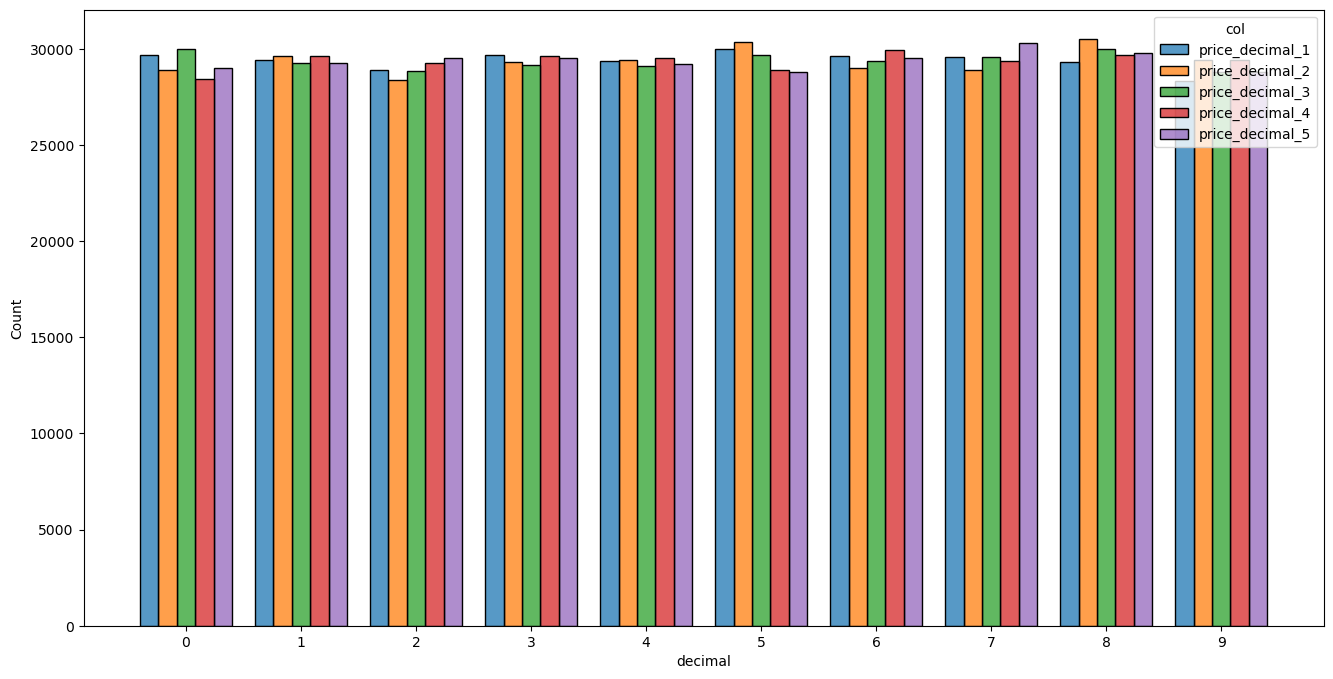

chi2_stat: 117.10539394228218,
p_value: 5.2232649693939665e-21


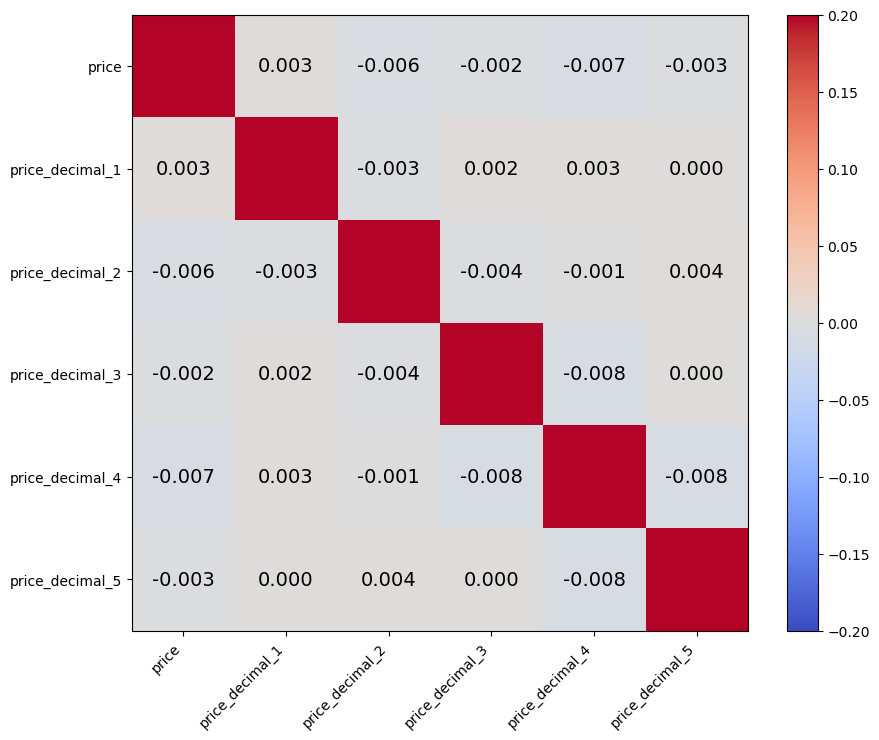

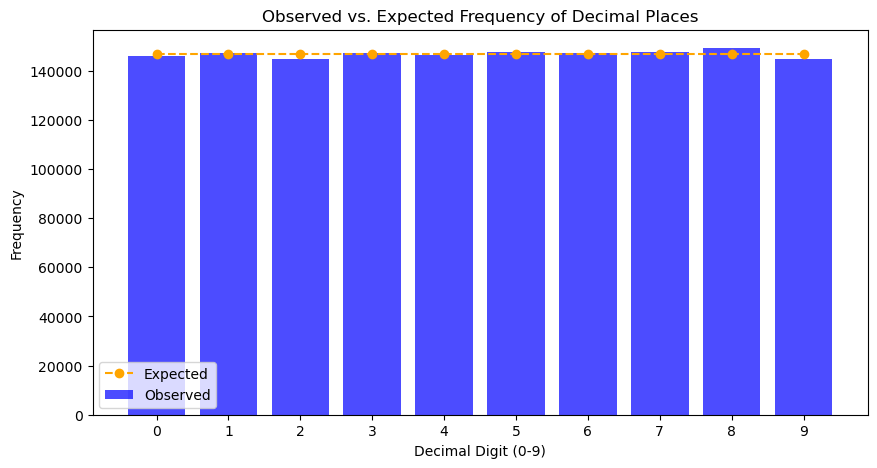

,Deviation (%)
0,-0.593654
1,0.171560
2,-1.384057
3,0.242363
4,-0.157264
5,0.560975
6,0.398265
7,0.570507
8,1.640717
9,-1.449413


Count of rows where the value has no decimal places:


,weight_capacity,count
0,-1.0,138
1,5.0,4286
2,30.0,185


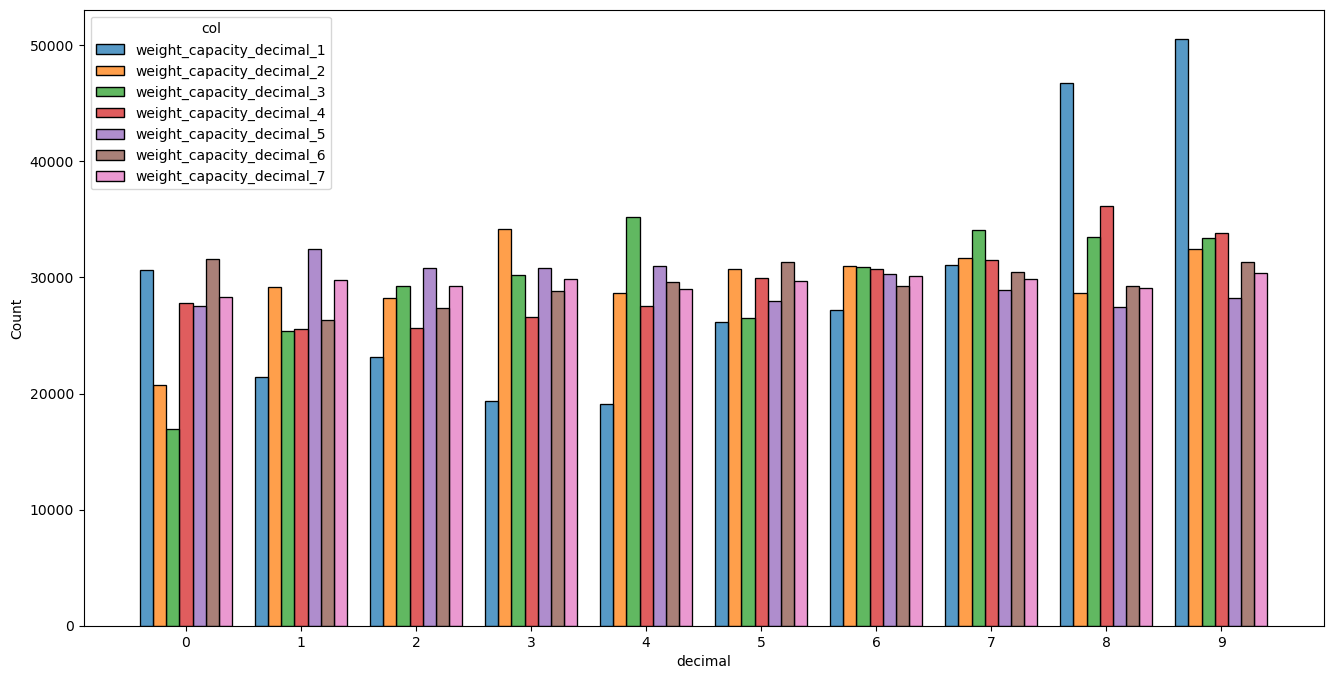

chi2_stat: 14060.22689587699,
p_value: 0.0


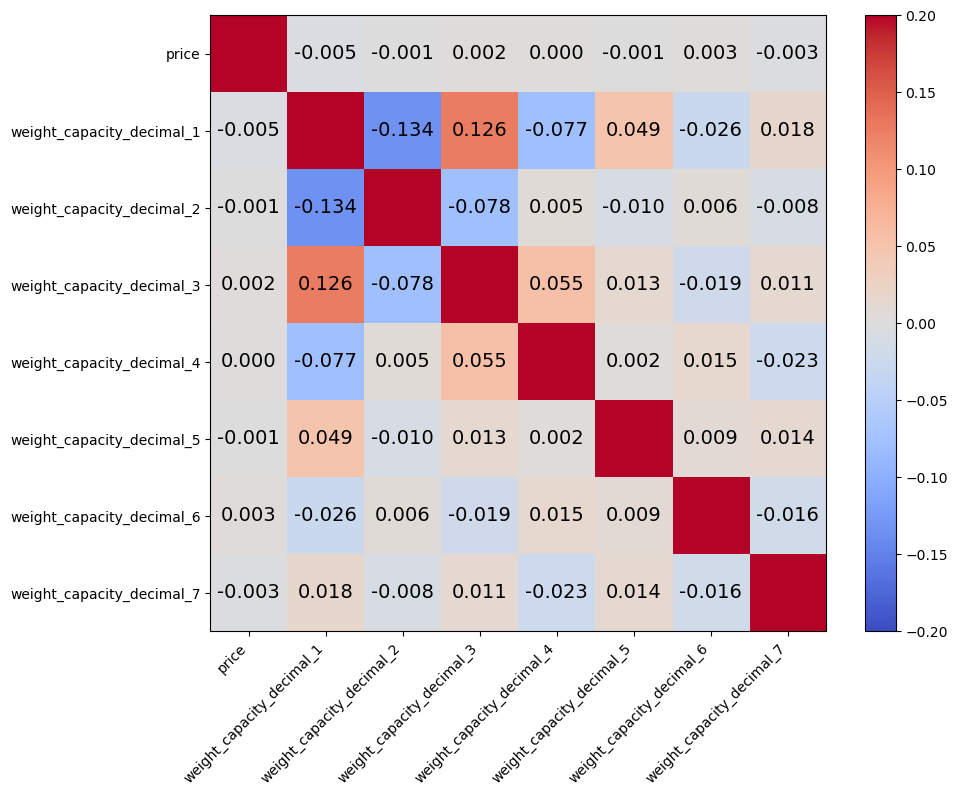

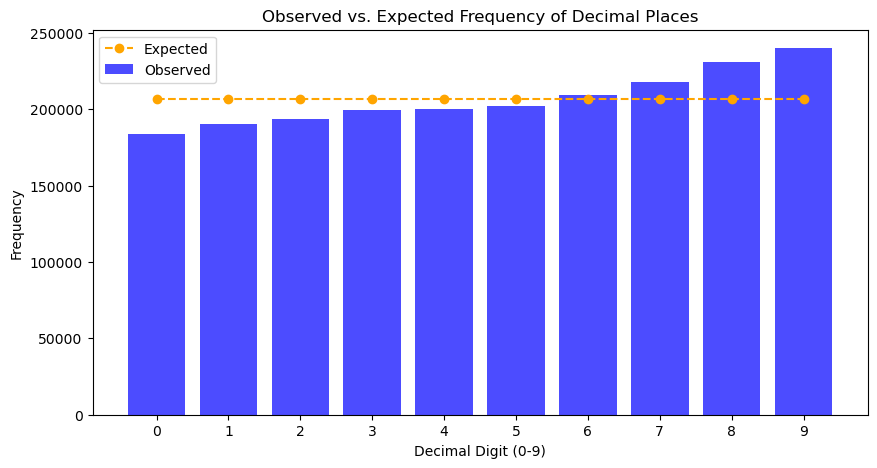

,Deviation (%)
0,-11.200506
1,-8.046816
2,-6.301430
3,-3.376010
4,-3.242047
5,-2.156802
6,1.367824
7,5.244526
8,11.599783
9,16.111478


In [94]:
def analyze_decimals(train_df, num_col='weight_capacity', precision=7):
    dec_cols = []
    for n in range(1, precision):
        new_col = f"{num_col}_decimal_{n}"
        train_df[new_col] = (train_df[num_col] * 10**n).astype(int) % 10
        dec_cols.append(new_col)

    not_even = train_df[train_df[num_col] != train_df[num_col].round(0)]
    even = train_df[train_df[num_col] == train_df[num_col].round(0)]
    rounded_counts = (
        # even.groupby(num_col, as_index=False)[num_col].count()
        even.reset_index()
        .groupby(num_col, as_index=False)['index'].count()
        .rename(columns={'index': 'count'})
    )
    print("Count of rows where the value has no decimal places:")
    display(rounded_counts)

    combined = []
    for col in dec_cols:
        combined.append(
            pd.DataFrame({
                "decimal": not_even[col], 
                'col': col})
        )
    combined = pd.concat(combined)

    # convert to string for plotting
    combined['decimal'] = combined['decimal'].astype(str)
    plt.figure(figsize=(16,8))
    sns.histplot(combined.sort_values(by=['decimal', 'col']), x='decimal', hue='col', multiple="dodge", shrink=0.8)
    plt.show()
    
    # plt.figure(figsize=(10, 8))  # Increase figure size
    # sns.heatmap(not_even[['price'] + dec_cols].corr(), 
    #             annot=True, 
    #             fmt=".6f", 
    #             vmin=-0.01,  # Set a smaller range for visibility
    #             vmax=0.01, 
    #             center=0, 
    #             annot_kws={"size": 10, "color": "white"},
    #             # annot_kws={"size": 10},  # Increase font size
    #             cmap="coolwarm")  # Use a color scheme with better contrast
    # plt.show()
    # plt.figure(figsize=(10, 8))  # Adjust as needed
    # sns.heatmap(not_even[['price']+dec_cols].corr(), annot=True, fmt=".6f") #, vmax=.1, )
    # plt.show()


    corr_matrix = not_even[['price'] + dec_cols].corr().values

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(corr_matrix, cmap="coolwarm", vmin=-0.2, vmax=0.2)
    fig.colorbar(cax)

    # Set axis labels
    ax.set_xticks(np.arange(len(dec_cols) + 1))  # +1 for 'price'
    ax.set_yticks(np.arange(len(dec_cols) + 1))
    ax.set_xticklabels(['price'] + dec_cols, rotation=45, ha="right")
    ax.set_yticklabels(['price'] + dec_cols)

    # Annotate each cell with correlation values
    for i in range(len(dec_cols) + 1):
        for j in range(len(dec_cols) + 1):
            if j == i:
                continue
            ax.text(j, i, f"{corr_matrix[i, j]:.3f}", size=14, ha="center", va="center", color="black")
    # corr_matrix = not_even[['price']+dec_cols].corr()
    # print(corr_matrix)


    # Expected frequencies assuming a uniform distribution (equal probability for each digit)
    observed_frequencies = combined.groupby('decimal').count().to_numpy().reshape(-1)
    # print(observed_frequencies)
    # return observed_frequencies
    expected_frequency = observed_frequencies.sum() / len(observed_frequencies)
    expected_frequencies = np.full_like(observed_frequencies, expected_frequency, dtype=np.float64)
    # expected_frequency = np.mean(observed_frequencies)
    # expected_frequencies = np.full_like(observed_frequencies, expected_frequency)
    chi2_stat, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
    print(f"chi2_stat: {chi2_stat},\np_value: {p_value}")

    decimals = np.arange(10)
    df = pd.DataFrame({"Decimal": decimals, "Observed": observed_frequencies, "Expected": expected_frequencies})

    # Plot observed vs expected frequencies
    plt.figure(figsize=(10, 5))
    plt.bar(df["Decimal"], df["Observed"], alpha=0.7, label="Observed", color='b')
    plt.plot(df["Decimal"], df["Expected"], marker='o', linestyle='dashed', color='#FFA500', label="Expected")

    plt.xlabel("Decimal Digit (0-9)")
    plt.ylabel("Frequency")
    plt.title("Observed vs. Expected Frequency of Decimal Places")
    plt.xticks(decimals)
    plt.legend()
    plt.show()

    # Checking deviation by computing percentage differences
    df["Deviation (%)"] = ((df["Observed"] - df["Expected"]) / df["Expected"]) * 100
    display(df[["Deviation (%)"]])

analyze_decimals(train_df, num_col='price', precision=6)
analyze_decimals(train_df, num_col='weight_capacity', precision=8)
# analyze_decimals(train_df, num_col='rng_normal', precision=7)

,weight_capacity,id
0,0.0,138
1,5.0,4286
2,30.0,185


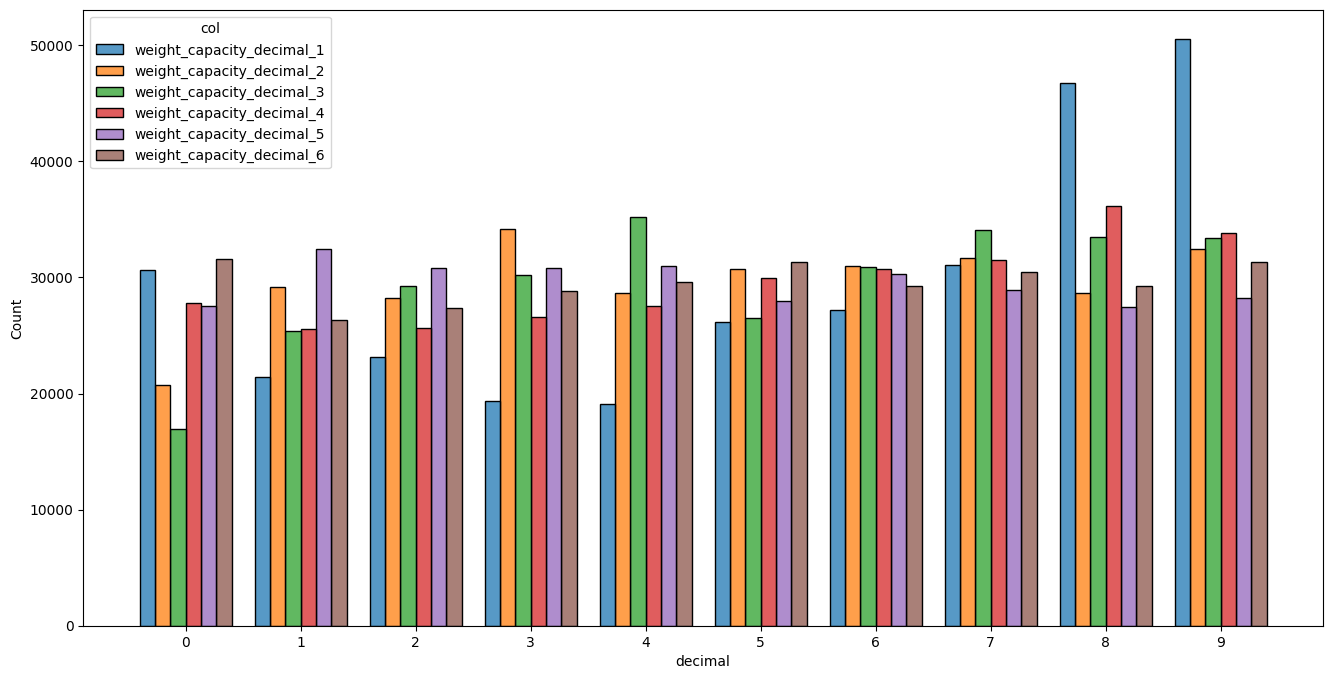

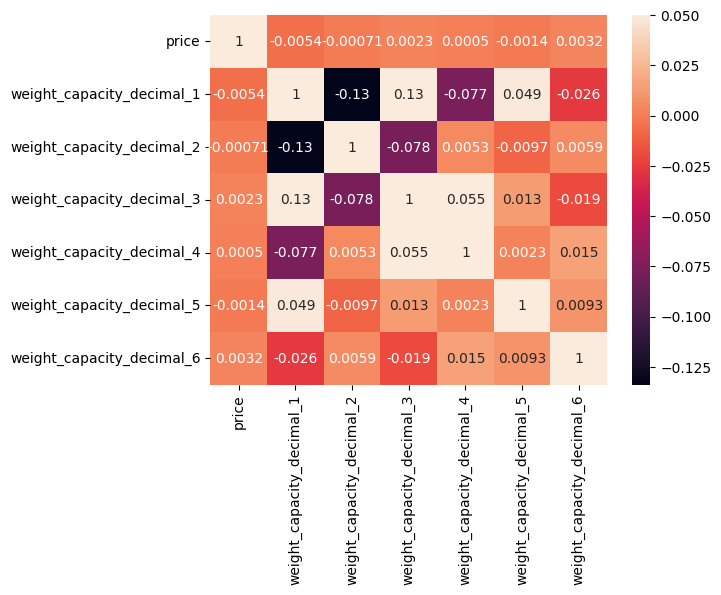

array([155310, 160332, 164443, 169964, 171049, 172635, 179441, 187777,
       201700, 209695])

In [198]:
# freq = analyze_decimals(train_df, num_col='price', precision=6)
freq = analyze_decimals(train_df, num_col='weight_capacity', precision=7)
freq

In [200]:
freq.sum()

np.int64(1772346)

In [201]:
expected_frequency

np.float64(177234.6)

In [203]:
expected_frequencies.sum()

np.int64(1772340)

In [ ]:
expected_frequency = np.mean(freq)
# expected_frequencies = np.round(np.full_like(freq, freq.sum() / len(freq))).astype(int)
# expected_frequencies = np.full_like(freq, expected_frequency)
# Due to rounding, there may still be a slight discrepancy, so 
# expected_frequencies[-1] += freq.sum() - expected_frequencies.sum()
expected_frequency = freq.sum() / len(freq)  # Ensures sum matches exactly
expected_frequencies = np.full_like(freq, expected_frequency, dtype=np.float64)
chi2_stat, p_value = stats.chisquare(f_obs=freq, f_exp=expected_frequencies)
chi2_stat, p_value

(np.float64(15857.707007548186), np.float64(0.0))

In [211]:
expected_frequencies

array([177234.6, 177234.6, 177234.6, 177234.6, 177234.6, 177234.6,
       177234.6, 177234.6, 177234.6, 177234.6])

In [206]:
expected_frequencies

array([177234, 177234, 177234, 177234, 177234, 177234, 177234, 177234,
       177234, 177240])

In [114]:
num_col = 'weight_capacity'
for n in range(1, 7):
    train_df[f"{num_col}_decimal_{n}"] = (train_df[num_col] * 10**n).astype(int) % 10

train_df[train_df[num_col] == train_df[num_col].round(0)].groupby(num_col, as_index=False)['id'].count()

,weight_capacity,id
0,0.0,138
1,5.0,4286
2,30.0,185


<Axes: xlabel='decimal', ylabel='Count'>

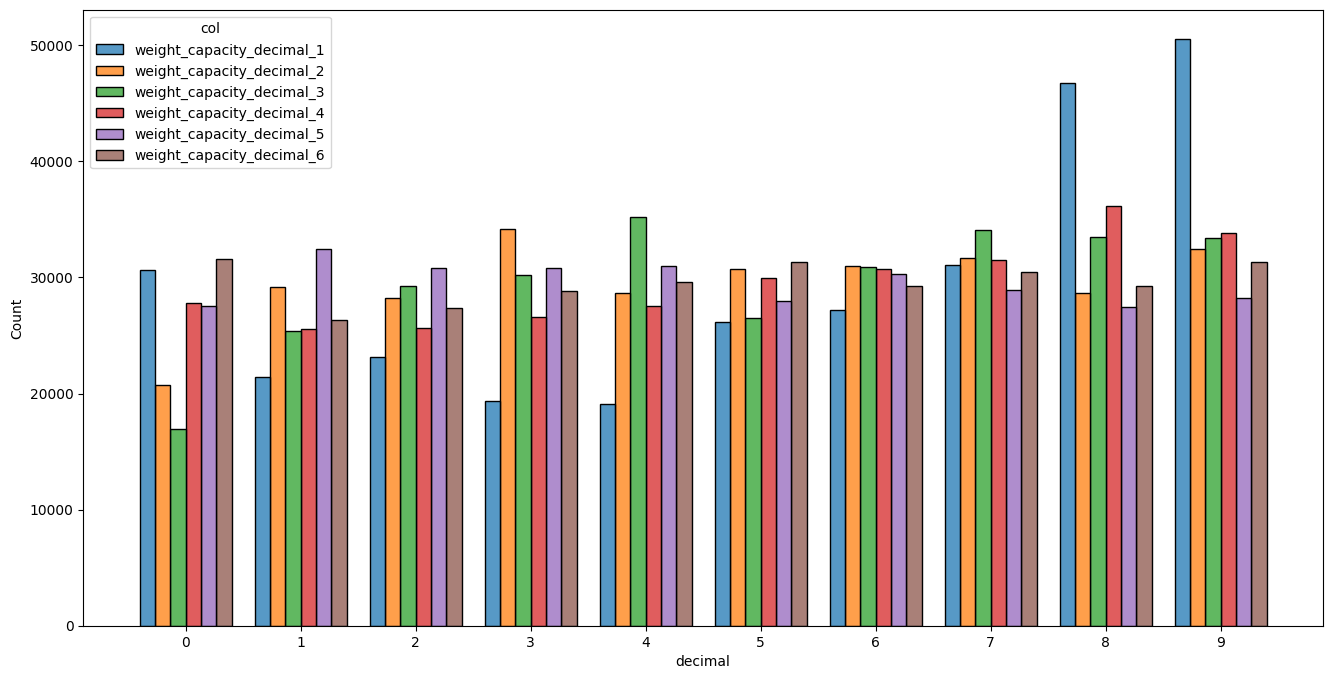

In [131]:
dec_cols = [f"{num_col}_decimal_{n}" for n in range(1, 7)]

not_even = train_df[train_df[num_col] != train_df[num_col].round(0)]
combined = []

for col in dec_cols:
    combined.append(
        pd.DataFrame({
            "decimal": not_even[col], 
            'col': col})
    )
    
combined = pd.concat(combined)

combined['decimal'] = combined['decimal'].astype(str)

plt.figure(figsize=(16,8))
sns.histplot(combined.sort_values(by=['decimal', 'col']), x='decimal', hue='col', multiple="dodge", shrink=0.8)

<Axes: >

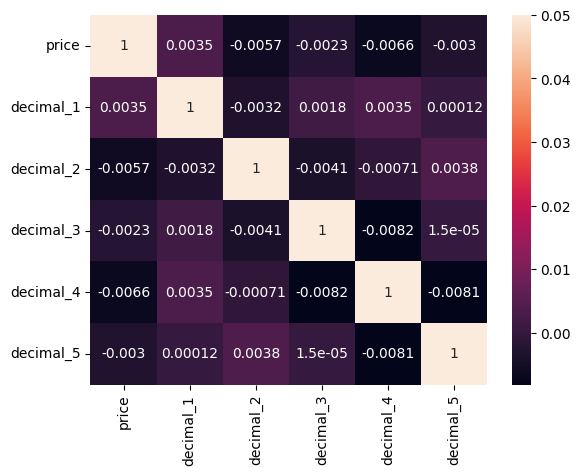

In [ ]:
# not_even[['price', 'weight_capacity_decimal_1']].corr()
sns.heatmap(not_even[['price']+dec_cols].corr(), vmax=.05, annot=True)


In [136]:
train_df

,id,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,...,decimal_2,decimal_3,decimal_4,decimal_5,weight_capacity_decimal_1,weight_capacity_decimal_2,weight_capacity_decimal_3,weight_capacity_decimal_4,weight_capacity_decimal_5,weight_capacity_decimal_6
0,0,Jansport,Leather,1,7,1,0,Tote,Black,11.611723,...,5,8,7,5,6,1,1,7,2,2
1,1,Jansport,Canvas,0,10,1,1,Messenger,Green,27.078537,...,8,0,5,6,0,7,8,5,3,6
2,2,Under Armour,Leather,0,2,1,0,Messenger,Red,16.643760,...,7,3,2,0,6,4,3,7,5,9
3,3,Nike,Nylon,0,8,1,0,Messenger,Green,12.937220,...,0,7,9,3,9,3,7,2,2,0
4,4,Adidas,Canvas,1,1,1,1,Messenger,Green,17.749338,...,2,3,1,2,7,4,9,3,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,0,9,0,0,Tote,Blue,12.730812,...,9,7,4,9,7,3,0,8,1,1
299996,299996,Jansport,Leather,2,6,0,1,Tote,Blue,26.633182,...,5,8,1,9,6,3,3,1,8,2
299997,299997,Puma,Canvas,2,9,1,1,Backpack,Pink,11.898250,...,1,3,6,4,8,9,8,2,4,9
299998,299998,Adidas,Nylon,0,1,0,1,Tote,Pink,6.175738,...,9,0,8,0,1,7,5,7,3,7


In [132]:
for n in range(1, 6):
    train_df[f"decimal_{n}"] = (train_df["price"] * 10**n).astype(int) % 10
train_df

,id,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,...,decimal_2,decimal_3,decimal_4,decimal_5,weight_capacity_decimal_1,weight_capacity_decimal_2,weight_capacity_decimal_3,weight_capacity_decimal_4,weight_capacity_decimal_5,weight_capacity_decimal_6
0,0,Jansport,Leather,1,7,1,0,Tote,Black,11.611723,...,5,8,7,5,6,1,1,7,2,2
1,1,Jansport,Canvas,0,10,1,1,Messenger,Green,27.078537,...,8,0,5,6,0,7,8,5,3,6
2,2,Under Armour,Leather,0,2,1,0,Messenger,Red,16.643760,...,7,3,2,0,6,4,3,7,5,9
3,3,Nike,Nylon,0,8,1,0,Messenger,Green,12.937220,...,0,7,9,3,9,3,7,2,2,0
4,4,Adidas,Canvas,1,1,1,1,Messenger,Green,17.749338,...,2,3,1,2,7,4,9,3,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,0,9,0,0,Tote,Blue,12.730812,...,9,7,4,9,7,3,0,8,1,1
299996,299996,Jansport,Leather,2,6,0,1,Tote,Blue,26.633182,...,5,8,1,9,6,3,3,1,8,2
299997,299997,Puma,Canvas,2,9,1,1,Backpack,Pink,11.898250,...,1,3,6,4,8,9,8,2,4,9
299998,299998,Adidas,Nylon,0,1,0,1,Tote,Pink,6.175738,...,9,0,8,0,1,7,5,7,3,7


In [133]:
train_df[train_df['price'] == train_df['price'].round(0)].groupby('price', as_index=False)['id'].count()

,price,id
0,15.0,693
1,148.0,5
2,150.0,5528


In [134]:
dec_cols = [f"decimal_{n}" for n in range(1, 6)]

not_even = train_df[train_df['price'] != train_df['price'].round(0)]
combined = []

for col in dec_cols:
    combined.append(
        pd.DataFrame({
            "decimal": not_even[col], 
            'col': col})
    )
    # sns.histplot(not_even[col])
    # plt.show()

combined = pd.concat(combined)

In [100]:
combined

,decimal,col
0,1,decimal_1
1,8,decimal_1
2,1,decimal_1
3,6,decimal_1
4,0,decimal_1
...,...,...
299995,9,decimal_5
299996,9,decimal_5
299997,4,decimal_5
299998,0,decimal_5


In [102]:
combined.groupby('decimal').count()

,col
decimal,
0,146015
1,147139
2,144854
3,147243
4,146656
5,147711
6,147472
7,147725
8,149297


<Axes: xlabel='decimal', ylabel='Count'>

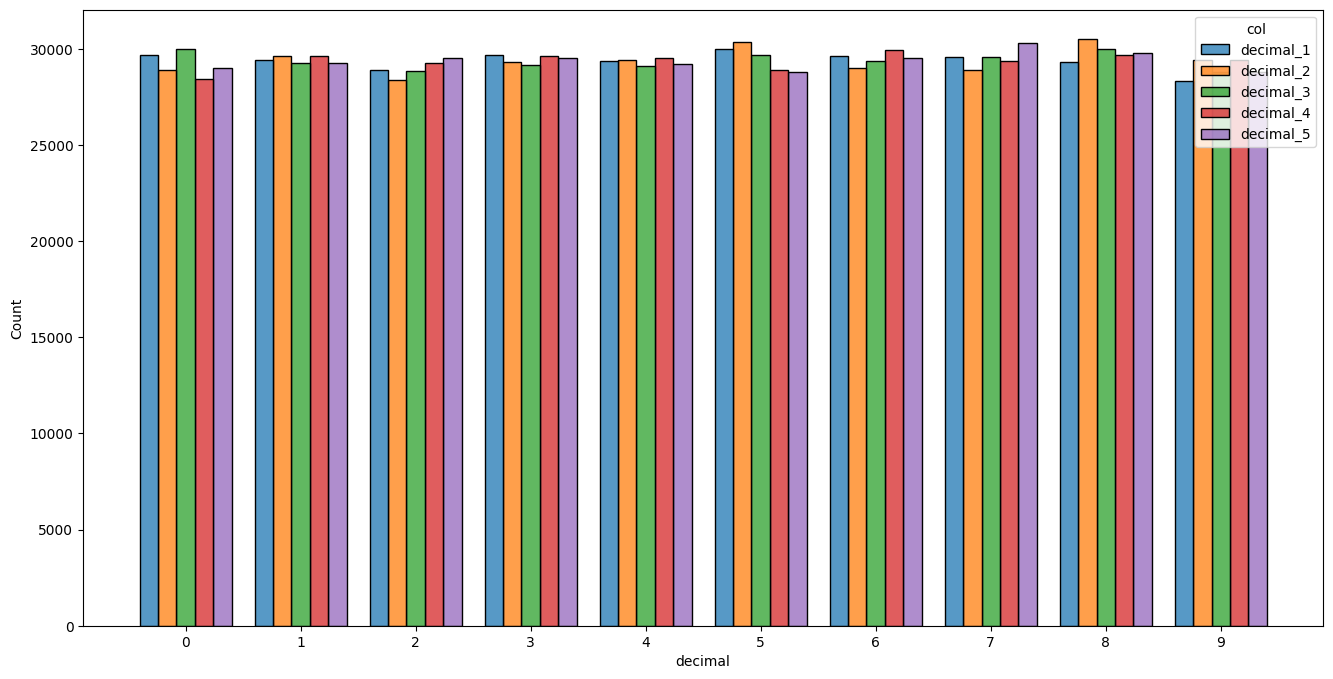

In [135]:
combined['decimal'] = combined['decimal'].astype(str)

plt.figure(figsize=(16,8))
sns.histplot(combined.sort_values(by=['decimal', 'col']), x='decimal', hue='col', multiple="dodge", shrink=0.8)

chi2_stat: 117.10539394228218,
p_value: 5.2232649693939665e-21


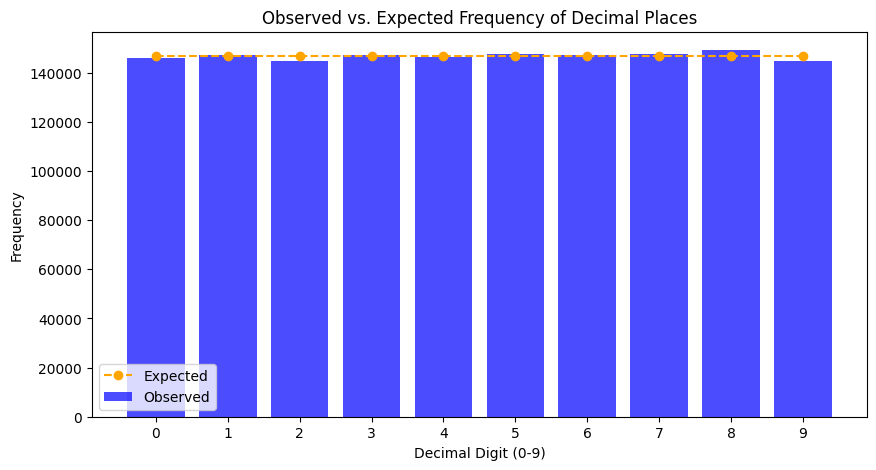

,Deviation (%)
0,-0.593654
1,0.171560
2,-1.384057
3,0.242363
4,-0.157264
5,0.560975
6,0.398265
7,0.570507
8,1.640717
9,-1.449413


In [ ]:
# Observed frequencies (from the provided data)
observed_frequencies = np.array([
    146015, 147139, 144854, 147243, 146656,
    147711, 147472, 147725, 149297, 144758
])

# Expected frequencies assuming a uniform distribution (equal probability for each digit)
expected_frequency = np.mean(observed_frequencies)  # Mean of observed counts
expected_frequencies = np.full_like(observed_frequencies, expected_frequency)

# Perform Chi-Square Goodness-of-Fit test
chi2_stat, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

# Output results
chi2_stat, p_value

(np.float64(117.10539394228218), np.float64(5.2232649693939665e-21))

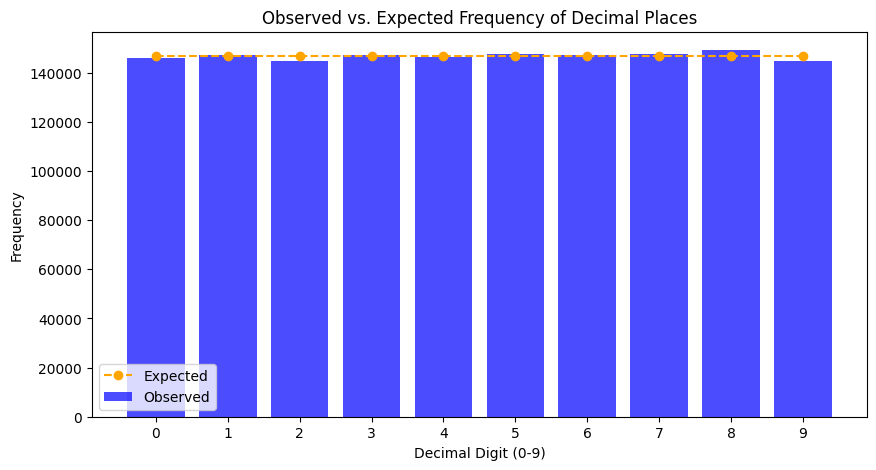

In [ ]:
decimals = np.arange(10)
df = pd.DataFrame({"Decimal": decimals, "Observed": observed_frequencies, "Expected": expected_frequencies})

# Plot observed vs expected frequencies
plt.figure(figsize=(10, 5))
plt.bar(df["Decimal"], df["Observed"], alpha=0.7, label="Observed", color='b')
plt.plot(df["Decimal"], df["Expected"], marker='o', linestyle='dashed', color='#FFA500', label="Expected")

plt.xlabel("Decimal Digit (0-9)")
plt.ylabel("Frequency")
plt.title("Observed vs. Expected Frequency of Decimal Places")
plt.xticks(decimals)
plt.legend()
plt.show()

# Checking deviation by computing percentage differences
df["Deviation (%)"] = ((df["Observed"] - df["Expected"]) / df["Expected"]) * 100


In [109]:
price_bins

array([144758. , 145782.8, 146945.8, 147334.6, 147713.8, 149297. ])

,Price_Range,Observed
0,Bin 1,289612
1,Bin 2,292671
2,Bin 3,294382
3,Bin 4,295183
4,Bin 5,297022


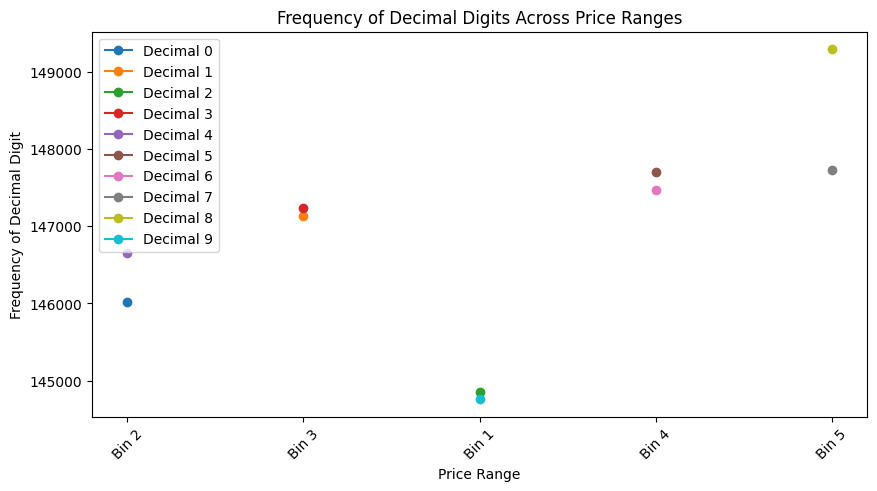

In [ ]:
# Investigating decimal place distribution across different price ranges

# Creating synthetic price ranges based on percentiles
price_bins = np.percentile(observed_frequencies, np.linspace(0, 100, 6))  # 5 bins
bin_labels = [f"Bin {i+1}" for i in range(len(price_bins) - 1)]
decimal_price_df = pd.DataFrame({
    "Price_Range": pd.cut(observed_frequencies, bins=price_bins, labels=bin_labels, include_lowest=True),
    "Decimal": decimals,
    "Observed": observed_frequencies
})

# Group by price range to see decimal frequency variations
price_range_distribution = decimal_price_df.groupby("Price_Range")["Observed"].sum()

# Displaying the price range distribution
display(price_range_distribution.reset_index())

# Checking if certain decimal digits are more common in specific price ranges
plt.figure(figsize=(10, 5))
for decimal in decimals:
    subset = decimal_price_df[decimal_price_df["Decimal"] == decimal]
    plt.plot(subset["Price_Range"], subset["Observed"], marker='o', linestyle='-', label=f"Decimal {decimal}")

plt.xlabel("Price Range")
plt.ylabel("Frequency of Decimal Digit")
plt.title("Frequency of Decimal Digits Across Price Ranges")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [81]:
train_df[[f"decimal_{n}" for n in range(1, 6)]]

,decimal_1,decimal_2,decimal_3,decimal_4,decimal_5
0,1,5,8,7,5
1,8,8,0,5,6
2,1,7,3,2,0
3,6,0,7,9,3
4,0,2,3,1,2
...,...,...,...,...,...
299995,9,9,7,4,9
299996,8,5,8,1,9
299997,4,1,3,6,4
299998,8,9,0,8,0


In [60]:
train_df[['rng_bin', 'price']].corr('spearman')

,rng_bin,price
rng_bin,1.00000,-0.00233
price,-0.00233,1.00000


In [61]:
id_mod_cols = []
for n in range(1, 5):
    col = f'id_mod_{n}'
    id_mod_cols.append(col)
    train_df[col] = train_df['id'] % n

In [62]:
for feature in ['weight_capacity', 'id', 'rng_bin', 'rng_uniform', 'rng_normal'] + id_mod_cols:
    print("\n", feature, "________________________")
    print(f"{train_df[[feature, 'price']].corr().loc["price", feature].item():.5f}")
    print(f"{train_df[[feature, 'price']].corr('spearman').loc["price", feature].item():.5f}")


 weight_capacity ________________________
0.01856
0.01787

 id ________________________
0.00203
0.00195

 rng_bin ________________________
-0.00237
-0.00233

 rng_uniform ________________________
0.00061
0.00061

 rng_normal ________________________
0.00253
0.00174

 id_mod_1 ________________________
nan
nan

 id_mod_2 ________________________
-0.00059
-0.00058

 id_mod_3 ________________________
-0.00153
-0.00149

 id_mod_4 ________________________
0.00208
0.00205


In [72]:
id_mod_cols = []
for n in range(2, 10000):
    col = f'id_mod_{n}'
    id_mod_cols.append(col)
    train_df[col] = train_df['id'] % n
    corr = train_df[[col, 'price']].corr().loc["price", col].item()
    if (corr > 0.02 and corr > 0) or (corr < 0 and corr < -0.02):
        print(col, corr)

In [70]:
for n in range(2, 10):
    col = f'weight_capacity_{n}'
    train_df[col] = train_df['weight_capacity'] % n
    corr = train_df[[col, 'price']].corr().loc["price", col].item()
    # print(col, corr)
    if (corr > 0.02 and corr > 0) or (corr < 0 and corr < -0.02):
        print(col, corr)

In [6]:
train_df[['id', 'price']].corr()

,id,price
id,1.00000,-0.00067
price,-0.00067,1.00000


In [8]:
train_df[['id', 'price']].corr('spearman')

,id,price
id,1.000000,-0.000656
price,-0.000656,1.000000
